In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
import numpy as np
import pywt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import optuna
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from category_encoders import LeaveOneOutEncoder
import ipywidgets as widgets
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten, Dropout, BatchNormalization
import xgboost as xgb
from sklearn.svm import SVR
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

import lightgbm as lgb
import catboost as cb
import warnings
import logging
# from tcn import TCN
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"


# **Prédiction du Volume de Trafic sur l'I-94 (Minneapolis-St Paul)**
**Dataset :** [Metro Interstate Traffic Volume](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume)  
Ce jeu de données provient de la plateforme **UCI Machine Learning Repository** et contient des données horaires sur le volume de trafic de l'autoroute I-94 uniquement en direction ouest de Minneapolis à St Paul.
Il inclut plusieurs facteurs pouvant influencer le trafic, tels que :  
- **Les conditions météorologiques** (température, précipitations, etc.)  
- **Les jours fériés et événements spéciaux**  

L'objectif de cette étude est de **prédire** le volume de trafic horaire en fonction des caractéristiques disponibles. Une telle prédiction pourrait faciliter la gestion du trafic, anticiper les embouteillages et contribuer à une meilleure planification urbaine.

Les données sont disponibles à un pas de temps **horaire**. Notre objectif sera de prédire le trafic à très court terme, sur un horizon allant de 1 à 5 heures.

En outre, cette analyse nous aidera à mieux **comprendre** l'impact des variables contextuelles et à identifier les tendances sous-jacentes de cette série temporelle.


## **1. Import et mise en forme de la donnée**

In [2]:
df = pd.read_csv(r'data\Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')
print(df.shape)
df.head(5)

(48204, 9)


holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

Nous avons identifié certaines observations dupliquées (au même pas de temps), où les volumes de trafic sont similaires, seules les variables météorologiques varient. Afin d'éviter toute redondance, nous supprimerons ces observations en conservant uniquement la première occurrence.

In [3]:
df.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
print(df.shape)

(40575, 9)


In [4]:
missing_percentage = (df.isna().sum() / len(df)) * 100
rounded_missing_percentage = round(missing_percentage, 2)
print(rounded_missing_percentage[rounded_missing_percentage > 0])

holiday    99.87
dtype: float64


A priori, aucune valeur manquante n’est présente, à l’exception de la colonne **holiday**, bien que cela semble simplement indiquer l’absence de jours fériés.

Néanmoins, certaines données sont absentes de manière implicite, car les timestamps ne sont pas continus. Autrement dit, il manque des observations pour certains jours et certaines heures.  
Regardons celà plus en détail:

In [5]:
df['date_time'] = pd.to_datetime(df['date_time'])
start, end = df['date_time'].min(), df['date_time'].max()
full_range = pd.date_range(start=start, end=end, freq='h')

missing_timestamps = full_range.difference(df['date_time'])

print("Timestamps manquants :")
print(len(missing_timestamps) / len(full_range) * 100)


gaps = (missing_timestamps[1:] - missing_timestamps[:-1]) != pd.Timedelta(hours=1)
gap_indices = [0] + (gaps.nonzero()[0] + 1).tolist() + [len(missing_timestamps)]

longest_gap = max(
    (missing_timestamps[gap_indices[i]:gap_indices[i+1]] for i in range(len(gap_indices)-1)),
    key=len
)

print("\nLa plus longue période de données manquantes est de", len(longest_gap), "heures : entre le", longest_gap.min(), "et le", longest_gap.max())

missing_by_year = pd.Series(missing_timestamps).dt.year.value_counts().sort_index()
print("\nValeurs manquantes par années")
print(missing_by_year)

Timestamps manquants :
22.78929040360792

La plus longue période de données manquantes est de 7386 heures : entre le 2014-08-08 02:00:00 et le 2015-06-11 19:00:00

Valeurs manquantes par années
2012      72
2013    1466
2014    4259
2015    5167
2016     946
2017      47
2018      19
Name: count, dtype: int64


On observe une quantité importante de valeurs manquantes entre **2013 et 2015**, avec une interruption particulièrement longue de près d'un an, entre **août 2014 et juin 2015**.

Au total, près de **23%** des données sont manquantes, rendant toute tentative d'imputation non seulement risquée, mais surtout incohérente compte tenu de cette absence prolongée.

Afin de garantir la qualité des analyses, nous choisissons donc d'exclure la première moitié du dataset et de ne conserver qu'environ les 3,5 dernières années.  
Étant donné la taille initiale du dataset, cette réduction ne compromet pas la quantité de données disponibles, nous permettant ainsi de poursuivre une modélisation fiable.

In [6]:
df = df[(df["date_time"] >= "2015-10-27 07:00:00")]
print("Nombre d'observations (non manquantes) après tronquage : ", df.shape[0])
start, end = df['date_time'].min(), df['date_time'].max()
full_range = pd.date_range(start=start, end=end, freq='h')
print("Etendue du jeu de données : ", len(full_range))

missing_timestamps = full_range.difference(df['date_time'])

print("\nTimestamps manquants :")
print(len(missing_timestamps) / len(full_range) * 100)

gaps = (missing_timestamps[1:] - missing_timestamps[:-1]) != pd.Timedelta(hours=1)
gap_indices = [0] + (gaps.nonzero()[0] + 1).tolist() + [len(missing_timestamps)]

longest_gap = max(
    (missing_timestamps[gap_indices[i]:gap_indices[i+1]] for i in range(len(gap_indices)-1)),
    key=len
)

print("\nLa plus longue période de données manquantes est de", len(longest_gap), "heures : entre le", longest_gap.min(), "et le", longest_gap.max())


# missing value per year
missing_by_year = (pd.Series(missing_timestamps).dt.year.value_counts()).sort_index()
print(missing_by_year)

Nombre d'observations (non manquantes) après tronquage :  23979
Etendue du jeu de données :  25672

Timestamps manquants :
6.594733561857276

La plus longue période de données manquantes est de 9 heures : entre le 2017-02-13 16:00:00 et le 2017-02-14 00:00:00
2015    681
2016    946
2017     47
2018     19
Name: count, dtype: int64


Ces différentes transformations nous laissera donc avec un jeu de données de presque 26 000 observations horaires lorsque nous aurons complété les pas de temps manquants.

## **2.Remplissage des valeurs manquantes**

 **Jours fériés**
- Remplacés par `'None'`, indiquant l’absence de jours fériés.

 **Variables catégorielles**
- Remplissage avec la **valeur la plus proche** (avant ou après).

 **Variables continues** (ex: volume de trafic)
- **Interpolation linéaire** pour lisser les données sans rupture brutale.

---

 **Interpolation Linéaire**
L'interpolation linéaire permet **d'estimer une valeur manquante** en traçant une **ligne droite** entre deux points connus.

Elle repose sur l'équation suivante :

$$
y = y_1 + \frac{(y_2 - y_1)}{(x_2 - x_1)} \times (x - x_1)
$$

où :  
$$
\begin{aligned}
& (x_1, y_1) \text{ et } (x_2, y_2) \text{ sont les points encadrant la valeur manquante,} \\
& x \text{ est la position du point à estimer,} \\
& y \text{ est la valeur interpolée.}
\end{aligned}
$$

In [7]:
full_df = pd.DataFrame({'date_time': full_range})
df = full_df.merge(df, on='date_time', how='left')
df['holiday'] = df['holiday'].fillna('None')
df[['temp', 'rain_1h', 'snow_1h', 'clouds_all']] = df[['temp', 'rain_1h', 'snow_1h', 'clouds_all']].interpolate(method='linear')
df[['weather_main', 'weather_description']] = df[['weather_main', 'weather_description']].ffill().bfill()
df.set_index("date_time", inplace=True)
df['traffic_volume'] = df['traffic_volume'].interpolate(method='linear')

print(df.isna().sum().sum())
print(len(df))

0
25672


## **3. Analyse exploratoire des données**

Nous menons à présent une analyse exploratoire approfondie afin de répondre aux principales questions que nous nous posons sur ces données.

**A quoi ressemble nos variables?**

In [8]:
df.describe()

temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  25672.000000  25672.000000  25672.000000  25672.000000    25672.000000
mean     281.707215      0.427575      0.000284     43.853381     3308.275962
std       12.469646     61.361121      0.008459     39.123228     1961.371753
min      243.390000      0.000000      0.000000      0.000000        0.000000
25%      272.590000      0.000000      0.000000      1.000000     1309.375000
50%      282.700000      0.000000      0.000000     40.000000     3503.500000
75%      292.074000      0.000000      0.000000     90.000000     4936.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000

La température présente une grande variabilité, avec une moyenne de 8,5°C, un minimum de -29,76°C et un maximum de 36,92°C, reflétant des conditions climatiques contrastées.  
La couverture nuageuse, avec une moyenne de 43,85 %, indique une alternance entre périodes ensoleillées et nuageuses.  
Les précipitations restent généralement faibles, bien que la valeur maximale de pluie enregistrée (9831,3 mm) puisse indiquer des anomalies ou erreurs dans les données. La neige est quasi inexistante avec une moyenne de 0,000284 mm par heure.  
Enfin, le volume de trafic affiche une forte variation, avec une moyenne de 3308 véhicules et un écart-type élevé (1961), illustrant des fluctuations importantes entre les heures creuses et les périodes de pointe.

**Comment évolue le traffic sur la période d'étude?**

Text(0.5, 1.0, 'Traffic Volume Over Time')

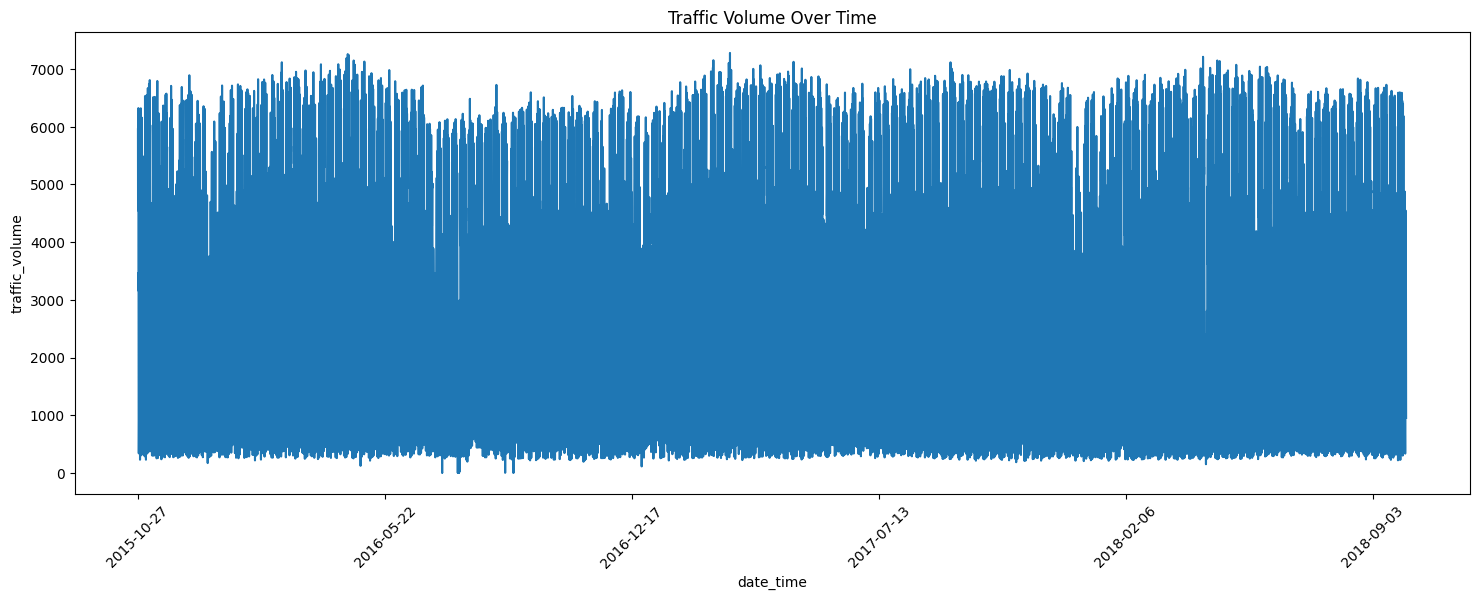

In [9]:
plt.figure(figsize=(18, 6))
sns.lineplot(x=df.index, y='traffic_volume', data=df)
plt.xticks(df.index[::5000], rotation=45)
plt.title('Traffic Volume Over Time')

- Présence de **pics** et de **creux** récurrents, reflétant des **cycles journaliers** et **hebdomadaires** caractéristiques des schémas de trafic urbain.
- **Pas de tendance nette à la hausse ou à la baisse** sur l’ensemble de la période. Une analyse plus fine sur des plages temporelles spécifiques pourrait révéler des tendances saisonnières ou des variations structurelles du trafic.

Les données étant denses, il est difficile de repérer des tendances ou des patterns intéressants. Pour améliorer la visualisation, nous allons utiliser des techniques de lissage des données, telles que la moyenne mobile (rolling window average) et la décomposition en ondelettes (wavelet decomposition).

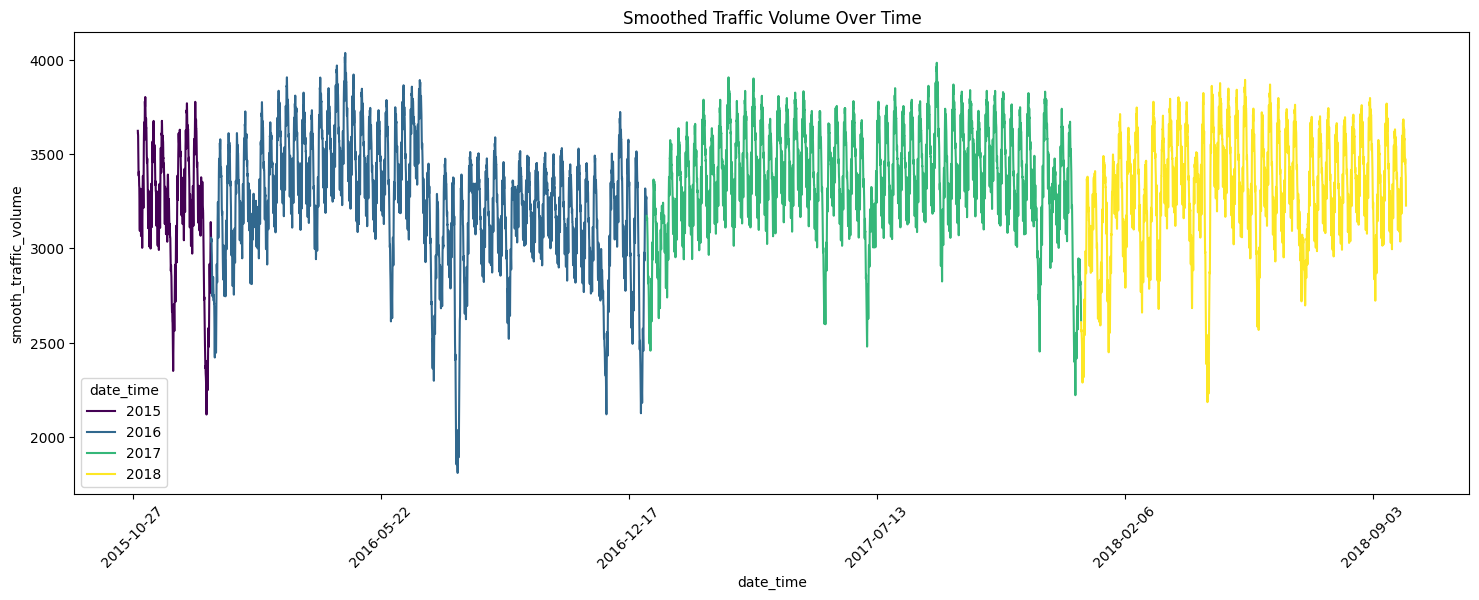

In [10]:
df['smooth_traffic_volume'] = df['traffic_volume'].rolling(window=100).mean()
colors = df.index.year
plt.figure(figsize=(18, 6))
sns.lineplot(x=df.index, y='smooth_traffic_volume', data=df, hue=colors, palette='viridis')
plt.xticks(df.index[::5000], rotation=45)
plt.title('Smoothed Traffic Volume Over Time')
plt.show()  

- Des **cycles saisonniers** récurrents sont visibles, caractérisés par des **pics réguliers** correspondant probablement aux **jours ouvrés** et des **creux** associés aux **week-ends** ou **jours fériés**.

Text(0.5, 1.0, 'Wavelet Decomposition')

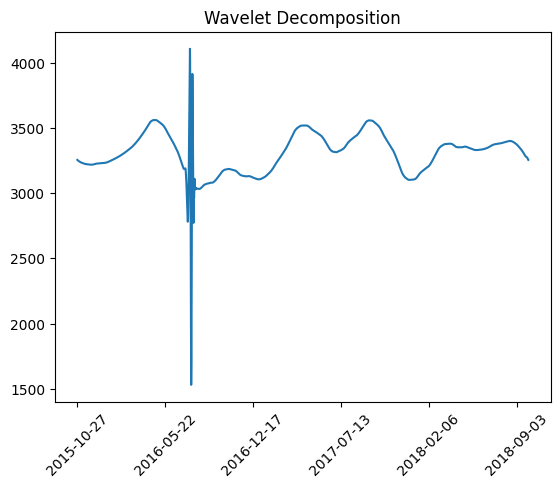

In [11]:
traffic_volume = df['traffic_volume']
coeff = pywt.wavedec(traffic_volume, 'db4', mode="per")
mean_coeff = np.mean([abs(ele - np.mean(traffic_volume)) for ele in traffic_volume])
sigma = (1 / 0.6745) * mean_coeff
threshhold = sigma * np.sqrt(2 * np.log(len(traffic_volume)))
coeff[1:] = (pywt.threshold(i, value=threshhold, mode='hard') for i in coeff[1:])
traffic_volume_wavelet_decomp = pywt.waverec(coeff, 'db4', mode='per')

plt.plot(df.index, traffic_volume_wavelet_decomp)
plt.xticks(df.index[::5000], rotation=45)
plt.title('Wavelet Decomposition')


La décomposition en ondelette est une technique utilisée en traitement du signal et en analyse de données pour décomposer un signal en composantes de fréquence différentes.  

Les ondelettes sont des fonctions mathématiques qui permettent de représenter des données ou des fonctions en termes de composantes de fréquence à différentes échelles. La transformation en ondelettes utilise des fonctions de base localisées dans le temps et la fréquence.

- La courbe met en évidence des **fluctuations de bas niveau** représentant la tendance de fond du volume de trafic.
- On observe des **oscillations régulières** correspondant à des cycles saisonniers ou des variations périodiques sur le long terme.
- Une **forte volatilité** est visible autour de la période de mi-2016, caractérisée par des **pics extrêmes** et des **variations soudaines**. En effet, un certain saut (baissier) est visible dans les données lissées à cette même période.

**Peut-on observer des différences entre les différents horizons temporels (mois, jour, heure...)?**

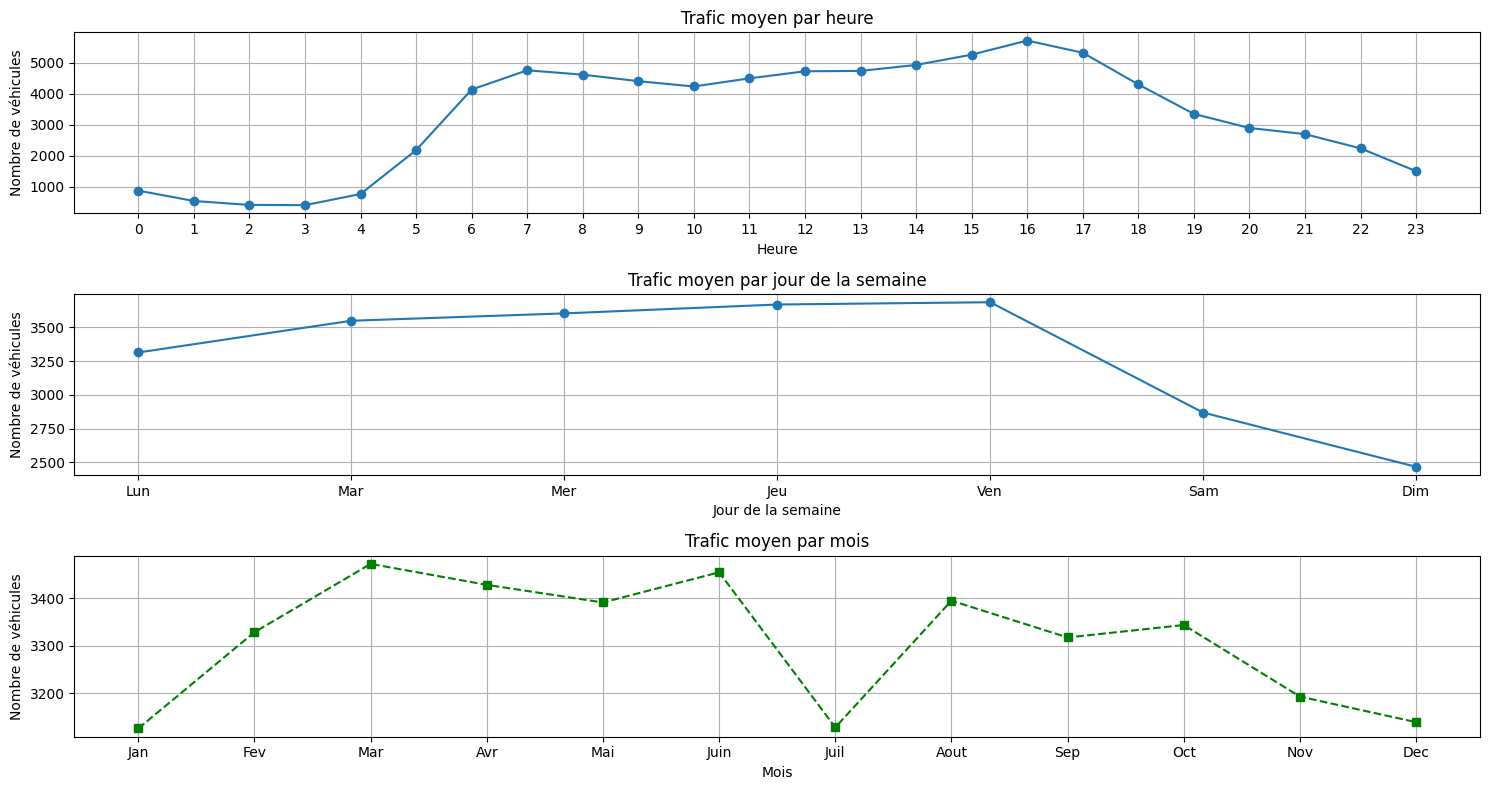

In [12]:
df["Hour"] = df.index.hour
df["Day"] = df.index.dayofweek 
df["Month"] = df.index.month

hourly_traffic = df.groupby("Hour")["traffic_volume"].mean()
daily_traffic = df.groupby("Day")["traffic_volume"].mean()
monthly_traffic = df.groupby("Month")["traffic_volume"].mean()

fig, axes = plt.subplots(3, 1, figsize=(15, 8))

axes[0].plot(hourly_traffic.index, hourly_traffic.values, marker='o')
axes[0].set_title("Trafic moyen par heure")
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Nombre de véhicules")
axes[0].grid(True)
axes[0].set_xticks(hourly_traffic.index)


axes[1].plot(daily_traffic.index, daily_traffic.values, marker='o', linestyle='-')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(["Lun", "Mar", "Mer", "Jeu", "Ven", "Sam", "Dim"])
axes[1].set_title("Trafic moyen par jour de la semaine")
axes[1].set_xlabel("Jour de la semaine")
axes[1].set_ylabel("Nombre de véhicules")
axes[1].grid(True)

axes[2].plot(monthly_traffic.index, monthly_traffic.values, marker='s', linestyle='--', color='g')
axes[2].set_title("Trafic moyen par mois")
axes[2].set_xlabel("Mois")
axes[2].set_ylabel("Nombre de véhicules")
axes[2].set_xticks(monthly_traffic.index)
axes[2].set_xticklabels(["Jan", "Fev", "Mar", "Avr", "Mai", "Juin", "Juil", "Aout", "Sep", "Oct", "Nov", "Dec"])
axes[2].grid(True)

plt.tight_layout()
plt.show()

Ces trois graphiques illustrent l’évolution du **trafic moyen** en fonction de l'heure, du jour de la semaine et du mois. Cette analyse permet de mieux comprendre les schémas de trafic récurrents et d’identifier les périodes de forte ou faible affluence.

**Trafic Moyen par Heure**

- Le trafic est **très faible entre minuit et 5h du matin**, avec un minimum autour de 3h.
- À partir de **6h**, une forte augmentation est observée, atteignant un **pic entre 7h et 8h**, correspondant à l’**heure de pointe matinale**.
- Un second **pic significatif vers 16h-17h**, typique des **heures de sortie de bureau**.
- Le trafic diminue progressivement après 18h, pour revenir à des niveaux bas en fin de soirée.
- Ce schéma est caractéristique d’un trafic influencé par des **déplacements domicile-travail**.

**Trafic Moyen par Jour de la Semaine**

- Le **trafic est le plus élevé du lundi au vendredi**, avec un **pic le jeudi et vendredi**, signe d’une activité intense en semaine.
- Le **week-end (samedi et dimanche)** enregistre une **baisse significative du trafic**, en particulier le dimanche, jour de trafic le plus faible.
- La différence nette entre semaine et week-end reflète un trafic dominé par les **activités professionnelles** en semaine et des déplacements plus sporadiques le week-end.

**Trafic Moyen par Mois**

- Le trafic reste **relativement stable tout au long de l'année**, avec quelques variations :
  - **Pic en mars et juin**, indiquant des périodes d’activité plus soutenue.
  - **Baisse notable en juillet et août**, probablement en raison des **vacances d’été**.
  - Légère diminution du trafic en décembre, en lien avec les **fêtes de fin d'année**.

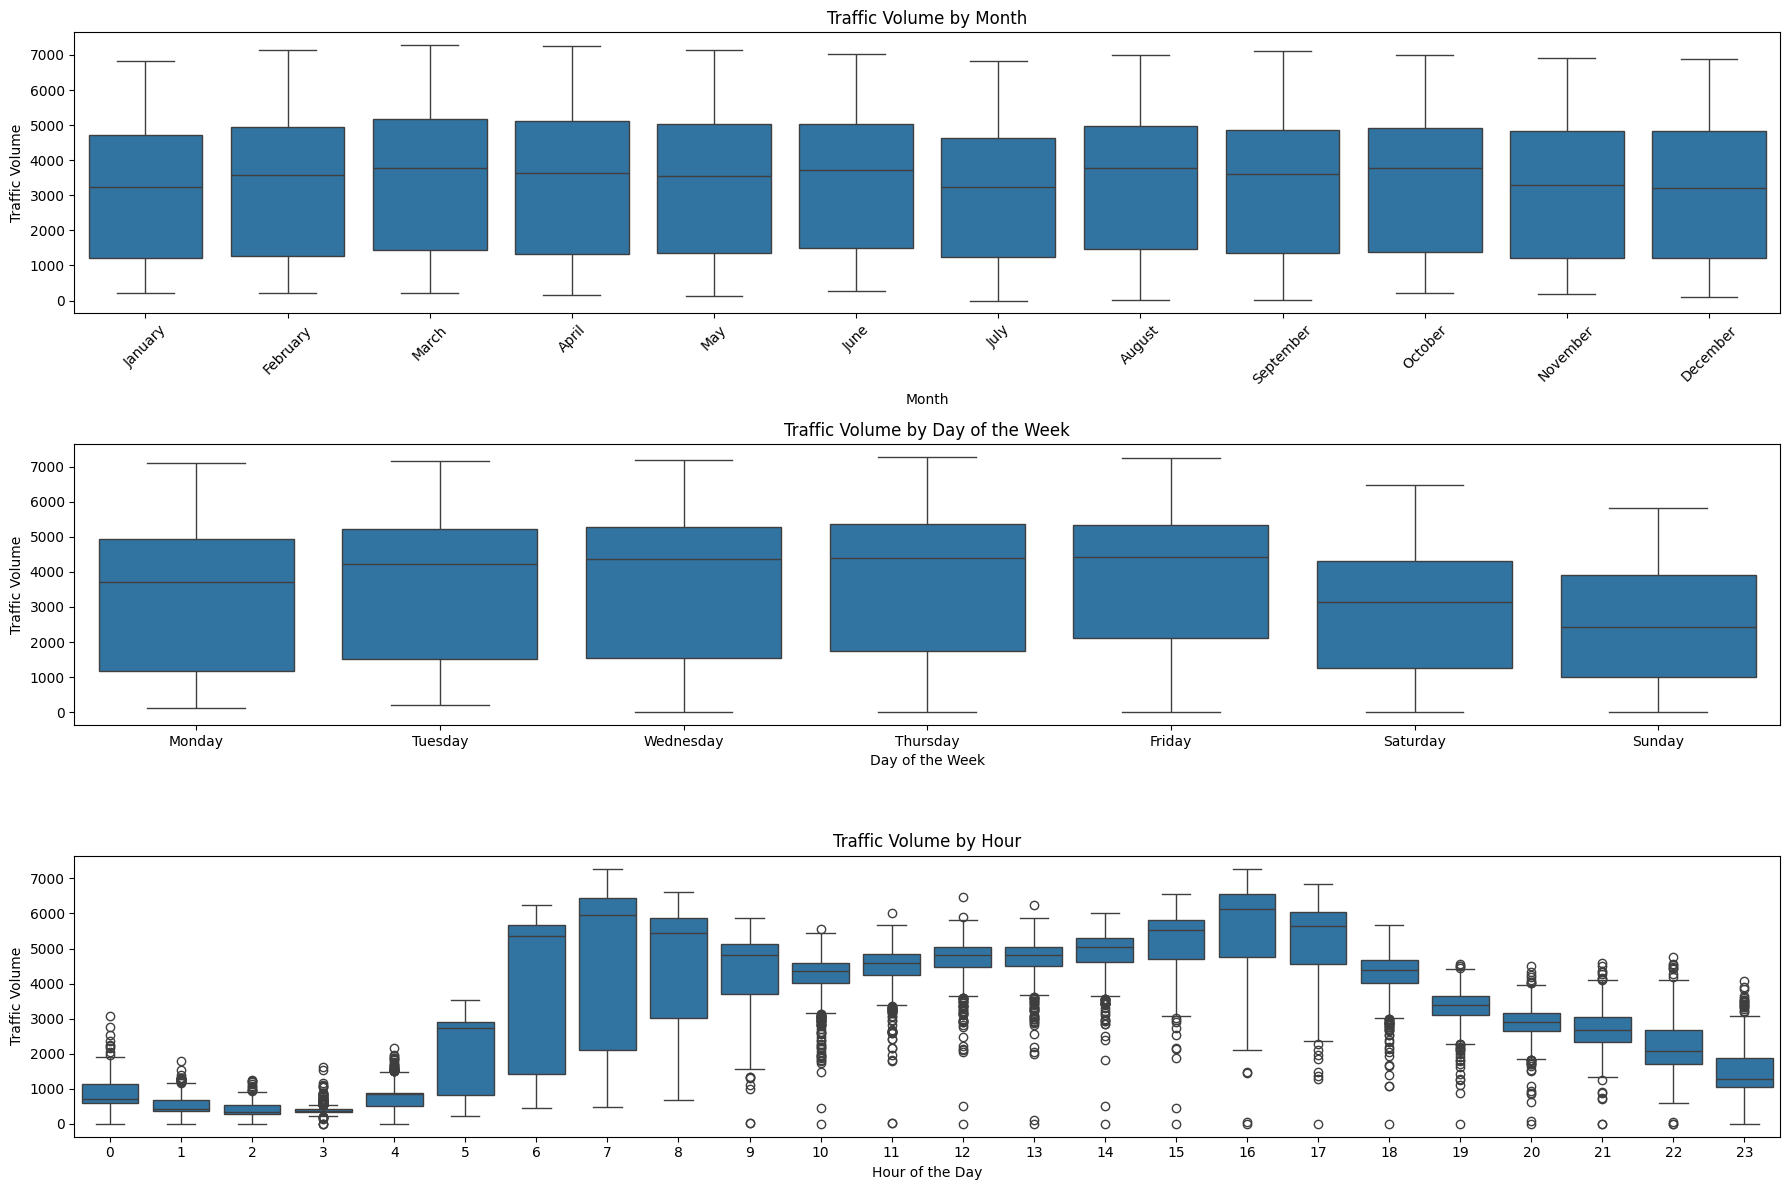

In [13]:
df['Month'] = pd.Categorical(df.index.month_name(), categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)

df['Day'] = pd.Categorical(df.index.day_name(), categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
df['Hour'] = df.index.hour

fig, axes = plt.subplots(3, 1, figsize=(18, 12)) 

sns.boxplot(x='Month', y='traffic_volume', data=df, ax=axes[0])
axes[0].set_title('Traffic Volume by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Traffic Volume')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Day', y='traffic_volume', data=df, ax=axes[1])
axes[1].set_title('Traffic Volume by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Traffic Volume')

sns.boxplot(x='Hour', y='traffic_volume', data=df, ax=axes[2])
axes[2].set_title('Traffic Volume by Hour')
axes[2].set_xlabel('Hour of the Day')
axes[2].set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()


Les boxplots nous donnent certaines informations supplémentaires concernant la distribution du trafic selon la temporalité.

**Mois**
  - Les **écarts interquartiles (IQR)** sont similaires, montrant une **dispersion modérée** du trafic chaque mois.
  - **Présence d'outliers** dans tous les mois, reflétant des pics de trafic exceptionnels, possiblement liés à des événements ponctuels.

**Jours**
  - La **dispersion est plus importante en semaine**, ce qui peut indiquer des variations liées aux heures de pointe.
  - **Moins de variabilité le week-end**, probablement en raison de schémas de trafic plus homogènes et moins soumis aux contraintes horaires.
  - Des **outliers fréquents** en semaine, souvent associés à des pics de trafic inattendus (accidents, événements spéciaux, conditions météo).

**Heures**
  - Forte **dispersion pendant les heures de pointe**, signe de fluctuations importantes dues aux conditions de circulation.
  - Moins de variabilité en dehors des heures de pointe, notamment la nuit.
  - De nombreux **outliers identifiés en dehors des heures de pointe**, probablement dus à des événements imprévus affectant ponctuellement le trafic.

**La météo influence-t-elle le traffic?**

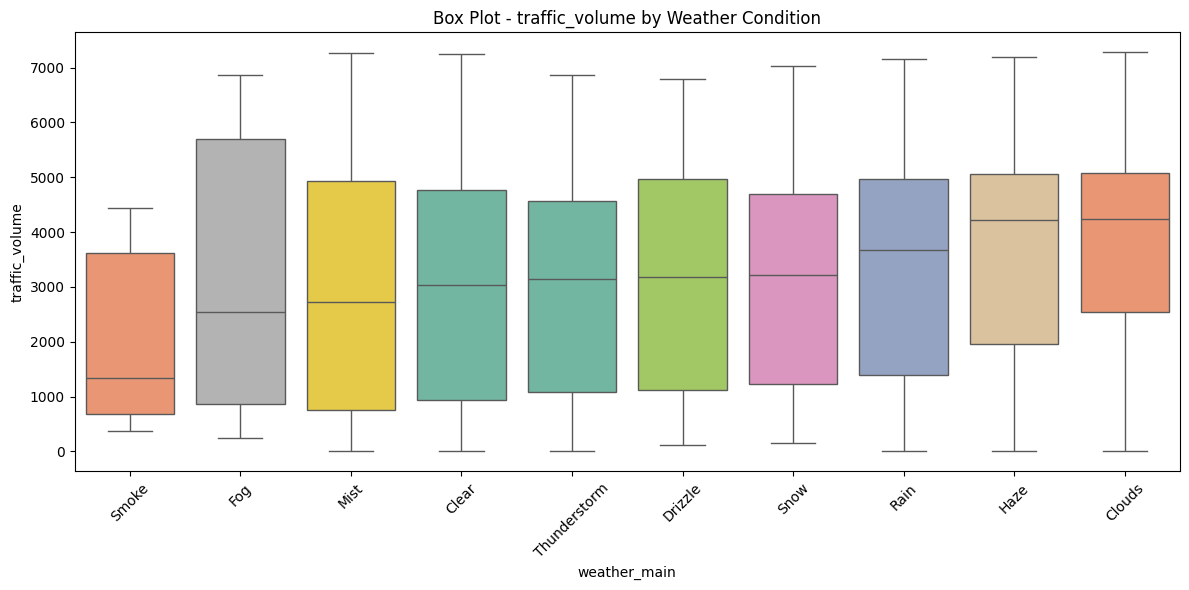

In [14]:
plt.figure(figsize=(12, 6))
sorted_weather = df.groupby('weather_main')['traffic_volume'].median().sort_values().index
sns.boxplot(x='weather_main', y='traffic_volume', hue='weather_main', data=df, order=sorted_weather, palette='Set2', legend=False)
plt.title('Box Plot - traffic_volume by Weather Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Le volume de trafic est relativement **variable** en fonction des conditions météorologiques.  
**Dispersion du traffic :**
  - **Mist, Fog, Haze** : Présentent des écarts interquartiles (IQR) importants, indiquant une **grande variabilité du trafic**.
  - **Thunderstorm** et **Snow** : Affichent des **outliers fréquents**, suggérant des pics de trafic inhabituels en raison d'événements exceptionnels (accidents, ralentissements, etc.).
  - **Clear** et **Clouds** : La distribution est plus **concentrée**, signe d’une circulation plus prévisible par temps clair ou nuageux.

**Volume du traffic :**
- Le **volume de trafic médian le plus élevé** est observé sous des conditions de **Clouds** et de **Haze**.
- Le **volume de trafic le plus faible** est constaté par temps de **Smoke** (fumée), suivi de conditions de **Mist** et de **Fog**.

**Conclusions :**
- **Clouds et Haze** sont des conditions météo courantes, ce qui peut expliquer des volumes de trafic élevés.
- Le faible volume de trafic lors de conditions de **Smoke** peut être dû à des situations exceptionnelles (incendies, pollution dense) qui limitent la mobilité des véhicules.
- La **pluie (Rain)** et la **neige (Snow)** n’ont pas un impact négatif aussi important que prévu sur le volume médian, bien que la **dispersion** des valeurs (observée dans le boxplot) indique des effets ponctuels plus marqués.

**Est-il possible de décomposer le trafic en composantes saisonnières ?**

In [15]:
result = seasonal_decompose(df["traffic_volume"], model='additive')

def plot_seasonal_decompose(result: DecomposeResult, title="Seasonal Decomposition"):
    return (
        make_subplots(
            rows=3,
            cols=1,
            subplot_titles=["Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=result.trend.index, y=result.trend, mode="lines"),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.seasonal, mode="lines"),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.resid.index, y=result.resid, mode="lines"),
            row=3,
            col=1,
        )
        .update_layout(
            height=900, title=title, margin=dict(t=100), title_x=0.5, showlegend=False
        )
    )

plot_seasonal_decompose(result).show()

Cette décomposition saisonnière permet d'analyser le volume de trafic à travers ses différentes composantes : **tendance**, **saisonnalité**, et **résidus**. L'objectif est de comprendre la structure sous-jacente des données et d'identifier des motifs récurrents ou des anomalies.

- La **tendance à long terme** est relativement stable avec quelques perturbations ponctuelles.
- Le volume de trafic est fortement influencé par des **cycles saisonniers réguliers** (quotidiens et hebdomadaires). *Il faut zoomer pour les voir.*
- Les **résidus** mettent en évidence des anomalies non capturées par la décomposition. Cela pourrait être dû à une variabilité du trafic en fonction d'autres facteurs comme les jours fériés, les événements spéciaux ou les conditions météorologiques.

**Les données présentent-elles un comportement autorégressif ?**

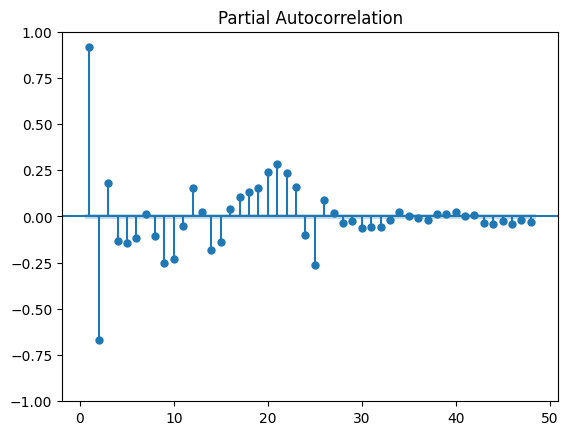

In [16]:
plot_pacf(df["traffic_volume"], lags=48, zero=False)
plt.show()

- Forte dépendance à court terme sur les lags 1 à 4.
- Effets saisonniers marqués, avec une forte autocorrélation autour du lag 24, probablement liée aux cycles quotidiens.
- La décroissance progressive de la corrélation confirme des schémas répétitifs à plusieurs échelles temporelles.  


Pour la modélisation, intégrer les lags proches et ceux de la veille comme variables prédictives permettrait d’enrichir l’information capturée par les modèles.

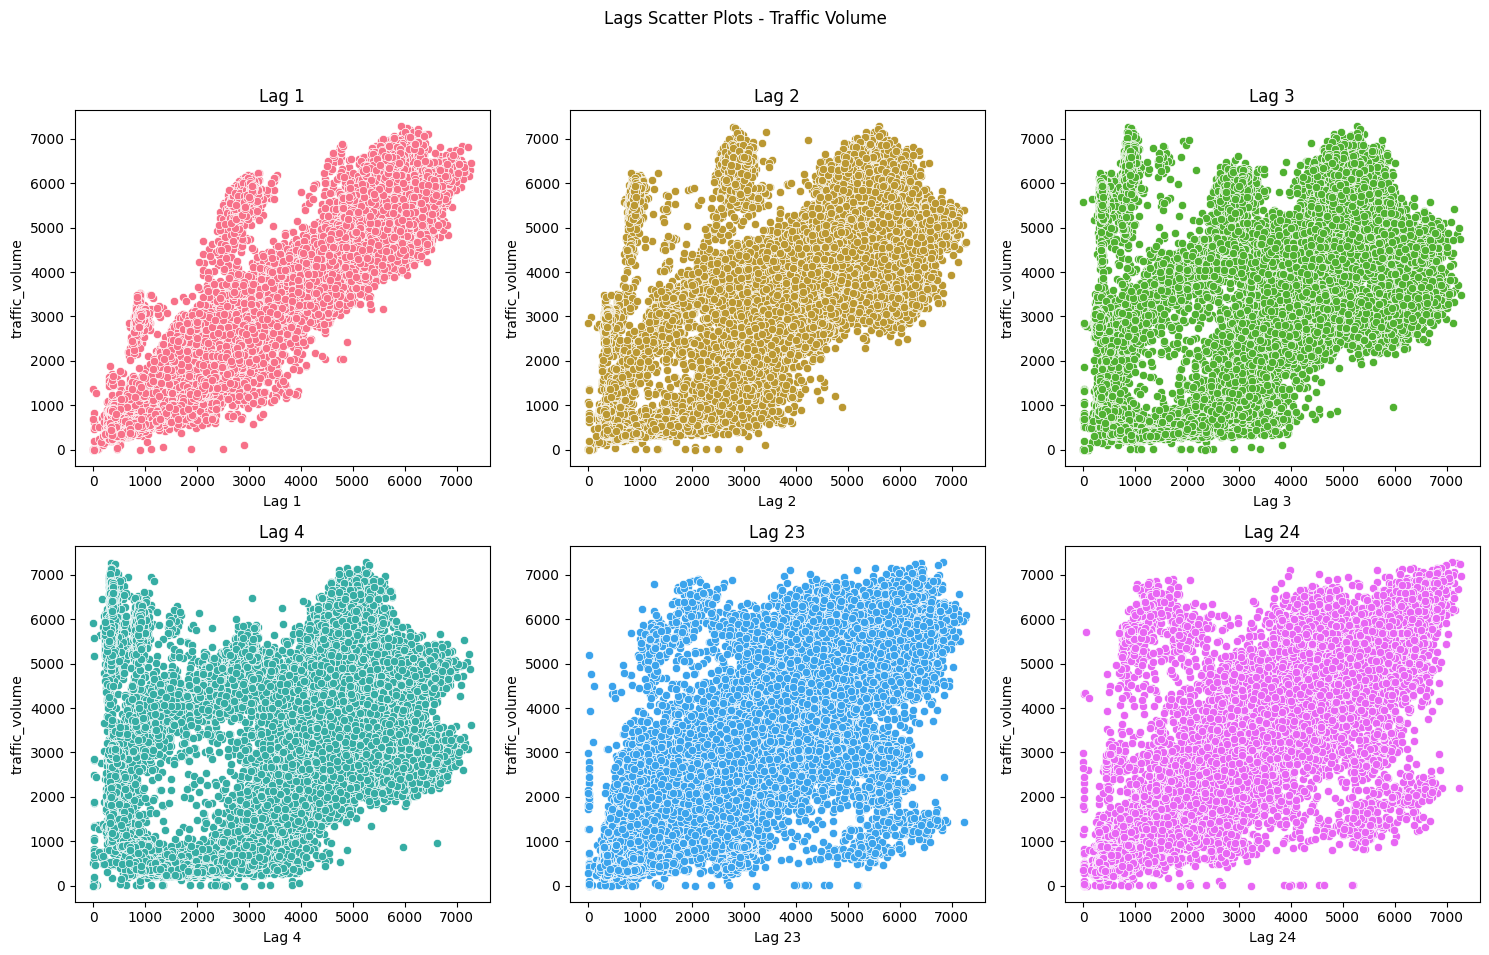

In [17]:
lags = [1, 2, 3, 4, 23, 24]
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Lags Scatter Plots - Traffic Volume')

for i, lag in enumerate(lags):
    ax = axs[i//3, i%3]
    lagged_data = df['traffic_volume'].shift(lag)
    sns.scatterplot(
        x=lagged_data, 
        y=df['traffic_volume'], 
        ax=ax,
        color=sns.color_palette("husl", len(lags))[i]
    )
    ax.set_title(f'Lag {lag}')
    ax.set_xlabel(f'Lag {lag}')
    ax.set_ylabel('traffic_volume')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

  - Forte **corrélation positive** visible, avec des points formant un nuage dense le long d’une diagonale ascendante.
  - Cela indique une **dépendance temporelle significative à court terme**, typique des séries temporelles avec des cycles de trafic réguliers (heures de pointe).


**Est ce que la série temporelle est stationnaire?**

In [18]:
result = adfuller(df['traffic_volume'])
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
if p_value < 0.05:
    print('La série est stationnaire')


ADF Statistic: -21.055681641193495
p-value: 0.0
La série est stationnaire


La série étant stationnaire, il n'est pas nécessaire de s'inquiéter des transformations qui auraient pu être requises (par exemple une différentiation)

## **3. Features engineering**

Grâce à l'analyse exploratoire, nous avons obtenu des insights précieux nous permettant de tester différentes techniques de feature engineering afin d'ajouter de l'information pertinente et d'améliorer la capacité prédictive de nos modèles.

**Intégration des lags dans nos variables explicatives**   
Nous choisissons d'inclure les valeurs des heures proches de l'heure 
𝑡
t afin de capturer les tendances immédiates, tout en ajoutant les valeurs de trafic des heures correspondantes de la veille pour exploiter d'éventuelles régularités journalières et améliorer la précision des prédictions.

In [19]:
lags = [1, 2, 3, 4, 23, 24]
for lag in lags:
    df[f'lag_{lag}'] = df['traffic_volume'].shift(lag)
df.dropna(inplace=True)

**Rajout de statistiques sur des fenêtres glissantes**  
L’ajout de statistiques sur des fenêtres glissantes permet d’extraire des tendances locales et d’enrichir le modèle avec des informations contextuelles.
On fera bien attention à ne pas inclure la valeur actuelle dans le calcul de ces aggrégats.

In [20]:
df['rolling_mean_daily'] = df['traffic_volume'].shift(1).rolling(window=24).mean()
df['rolling_mean_weekly'] = df['traffic_volume'].shift(1).rolling(window=24*7).mean()
df['rolling_mean_monthly'] = df['traffic_volume'].shift(1).rolling(window=24*30).mean()

df['rolling_median_daily'] = df['traffic_volume'].shift(1).rolling(window=24).median()
df['rolling_median_weekly'] = df['traffic_volume'].shift(1).rolling(window=24*7).median()
df['rolling_median_monthly'] = df['traffic_volume'].shift(1).rolling(window=24*30).median()

df['rolling_std_daily'] = df['traffic_volume'].shift(1).rolling(window=24).std()
df['rolling_std_weekly'] = df['traffic_volume'].shift(1).rolling(window=24*7).std()
df['rolling_std_monthly'] = df['traffic_volume'].shift(1).rolling(window=24*30).std()
   

**Extraction de variables temporelles (Jour de la semaine, mois, week-end...)**  
L’analyse exploratoire montre que le trafic varie selon le jour, le mois et les périodes spécifiques (week-ends, jours fériés). Les jours ouvrés présentent des schémas distincts des week-ends, tandis que les mois et saisons influencent la densité du trafic (ex. : vacances, fêtes). Intégrer ces variables permet d’affiner la prédiction en capturant ces tendances récurrentes.

In [21]:
df['Weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

Les variables temporelles comme le jour de la semaine, le mois ou l’heure sont cycliques : après le dimanche vient le lundi, après décembre vient janvier. Un encodage classique (0 à 6 pour les jours, 1 à 12 pour les mois) ne reflète pas cette continuité.  

L’encodage cyclique (via sinus et cosinus) préserve cette relation en transformant une variable périodique en coordonnées sur un cercle, permettant au modèle de percevoir la proximité entre le début et la fin du cycle.

Ainsi, les jours voisins ont des valeurs similaires et le modèle comprend la continuité du cycle.

In [22]:
df['Hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)

df['Day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df['Day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

df['Month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['Month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

In [23]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume', 'smooth_traffic_volume',
       'Hour', 'Day', 'Month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_23',
       'lag_24', 'rolling_mean_daily', 'rolling_mean_weekly',
       'rolling_mean_monthly', 'rolling_median_daily', 'rolling_median_weekly',
       'rolling_median_monthly', 'rolling_std_daily', 'rolling_std_weekly',
       'rolling_std_monthly', 'Weekend', 'Hour_sin', 'Hour_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos'],
      dtype='object')

**Choix des features et suppression des valeurs manquantes induites par la création de features**

In [24]:
df.dropna(inplace=True)
features = ['weather_main', 'traffic_volume', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_23',
       'lag_24', 'rolling_mean_daily', 'rolling_mean_weekly',
       'rolling_mean_monthly', 'rolling_median_daily', 'rolling_median_weekly',
       'rolling_median_monthly', 'rolling_std_daily', 'rolling_std_weekly',
       'rolling_std_monthly', 'Weekend', 'Hour_sin', 'Hour_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos']

df = df.loc[:, features]
print(df.shape)
df.head()

(24853, 24)


weather_main  traffic_volume   lag_1   lag_2   lag_3  \
date_time                                                                  
2015-11-30 11:00:00         Snow          3998.5  3930.0  4081.5  4233.0   
2015-11-30 12:00:00         Mist          4067.0  3998.5  3930.0  4081.5   
2015-11-30 13:00:00         Mist          4444.0  4067.0  3998.5  3930.0   
2015-11-30 14:00:00         Haze          4821.0  4444.0  4067.0  3998.5   
2015-11-30 15:00:00         Haze          4984.0  4821.0  4444.0  4067.0   

                      lag_4  lag_23  lag_24  rolling_mean_daily  \
date_time                                                         
2015-11-30 11:00:00  3863.5  4021.0  3592.5         2917.104167   
2015-11-30 12:00:00  4233.0  4187.0  4021.0         2934.020833   
2015-11-30 13:00:00  4081.5  4454.0  4187.0         2935.937500   
2015-11-30 14:00:00  3930.0  4841.0  4454.0         2946.645833   
2015-11-30 15:00:00  3998.5  5228.0  4841.0         2961.937500   

                     rolling_mean_weekly  ...  rolling_std_daily  \
date_time                                 ...                      
2015-11-30 11:00:00          2893.276786  ...        1637.969149   
2015-11-30 12:00:00          2889.339286  ...        1647.317671   
2015-11-30 13:00:00          2884.714286  ...        1648.663578   
2015-11-30 14:00:00          2882.785714  ...        1657.951194   
2015-11-30 15:00:00          2880.309524  ...        1674.072419   

                     rolling_std_weekly  rolling_std_monthly  Weekend  \
date_time                                                               
2015-11-30 11:00:00         1816.195929          1943.630821        0   
2015-11-30 12:00:00         1813.057101          1942.010185        0   
2015-11-30 13:00:00         1809.027584          1941.111678        0   
2015-11-30 14:00:00         1807.179586          1941.018564        0   
2015-11-30 15:00:00         1804.217107          1941.257375        0   

                         Hour_sin  Hour_cos  Day_sin  Day_cos  Month_sin  \
date_time                                                                  
2015-11-30 11:00:00  2.588190e-01 -0.965926      0.0      1.0       -0.5   
2015-11-30 12:00:00  1.224647e-16 -1.000000      0.0      1.0       -0.5   
2015-11-30 13:00:00 -2.588190e-01 -0.965926      0.0      1.0       -0.5   
2015-11-30 14:00:00 -5.000000e-01 -0.866025      0.0      1.0       -0.5   
2015-11-30 15:00:00 -7.071068e-01 -0.707107      0.0      1.0       -0.5   

                     Month_cos  
date_time                       
2015-11-30 11:00:00   0.866025  
2015-11-30 12:00:00   0.866025  
2015-11-30 13:00:00   0.866025  
2015-11-30 14:00:00   0.866025  
2015-11-30 15:00:00   0.866025  

[5 rows x 24 columns]

## **3(bis). Encodage des variables catégorielles et train/test split**

**Train/test split** : Nous divisons notre jeu de données en un jeu d'entraînement (80%) et un jeu de test (20%). Dans le cas des séries temporelles, il est essentiel de respecter l'ordre chronologique afin de préserver le contexte et éviter toute fuite de données.

**Encodage des variables catégorielles** : Les colonnes de type object ou category sont transformées à l'aide de l'encodage **Leave-One-Out (LOO)**. Cet encodage remplace chaque catégorie par la moyenne de la variable cible correspondante, en excluant l'observation en cours pour limiter le risque de surapprentissage.

In [25]:
X = df.drop(columns=['traffic_volume'])
y = df['traffic_volume']

train_size = int(0.8 * len(df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
loo_encoder = LeaveOneOutEncoder(cols=categorical_cols, sigma=0.0)
loo_encoder.fit(X_train, y_train)

X_train = loo_encoder.transform(X_train)
X_test  = loo_encoder.transform(X_test)

X_train.weather_main.value_counts()

weather_main
3713.215059    6740
3023.115969    6713
3291.352658    1975
2924.023047    1779
3141.414674    1547
3580.417258     423
3157.438776     343
2945.907328     232
2979.115702     121
1531.444444       9
Name: count, dtype: int64

In [26]:
corr = X_train.corrwith(y_train)
corr.sort_values(ascending=False)

lag_1                     0.913835
lag_24                    0.866655
lag_23                    0.796787
lag_2                     0.726229
lag_3                     0.514330
lag_4                     0.315402
rolling_std_daily         0.214866
rolling_mean_daily        0.180309
weather_main              0.164876
rolling_median_daily      0.164799
Day_sin                   0.158970
rolling_mean_weekly       0.092702
rolling_median_weekly     0.083191
rolling_mean_monthly      0.081955
rolling_std_weekly        0.080608
rolling_std_monthly       0.080340
rolling_median_monthly    0.078905
Month_sin                 0.020256
Month_cos                -0.037634
Day_cos                  -0.104005
Weekend                  -0.203811
Hour_sin                 -0.253370
Hour_cos                 -0.767899
dtype: float64

Le trafic est fortement influencé par les valeurs passées (lag_1, lag_24), indiquant une forte dépendance temporelle. Les tendances (rolling_mean/std), la météo et les jours de la semaine ont un impact modéré. Les cycles horaires (Hour_sin/cos) montrent une influence marquée, notamment sur les heures de pointe.

## **4. Modélisation**

#### **Choix de la métrique d'évaluation, de la stratégie d'évaluation et modèle naïf**

Dans notre approche de prévision du trafic routier, nous allons privilégier la **RMSE (Root Mean Squared Error)**, car cette métrique pénalise davantage les grandes erreurs. Étant donné que notre objectif est de détecter des valeurs extrêmes (pics de trafic, congestions inhabituelles), la RMSE nous aidera à mieux identifier les déviations importantes.

Nous utiliserons également la MAE (Mean Absolute Error) pour sa simplicité d’interprétation. Elle nous permettra d’avoir une idée claire de l’erreur moyenne en unités du trafic, facilitant ainsi la compréhension des performances du modèle.

Par ailleurs, nous examinerons le coefficient de détermination R2, qui mesure la proportion de la variance du trafic expliquée par notre modèle. Un 
R2 roche de 1 indique que notre modèle capture bien les variations du trafic. Cette métrique est particulièrement utile pour comparer différents modèles et s'assurer qu’ils ne se contentent pas de simples approximations.

In [27]:
def evaluate_predictions(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    return mae, rmse, r2

Nous évaluons un modèle dit "naïf" qui correspond à la valeur à la même heure du jour d'avant.

In [28]:
seasonal_naive = X_test['lag_24']
mae, rmse, r2 = evaluate_predictions(y_test, seasonal_naive)
print(f"Seasonal Naive Model: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")

Seasonal Naive Model: MAE=543.17, RMSE=1019.91, R2=0.74


Nous allons utiliser la méthode **Expanding Window Validation** pour évaluer notre modèle de prévision du trafic routier. Cette approche consiste à entraîner le modèle sur une période initiale, puis à l’évaluer sur une fenêtre de test suivante, tout en élargissant progressivement la fenêtre d'entraînement à chaque itération. Cela permet au modèle d’apprendre sur un historique de plus en plus large, reflétant mieux la nature évolutive du trafic. Cette méthode garantit une évaluation réaliste, car elle respecte la temporalité des données et permet de mesurer la capacité du modèle à s’adapter aux nouvelles tendances et variations saisonnières.

In [29]:
def expanding_window_evaluation(model, X_train, y_train, X_test, y_test, n_splits=5, verbose = True):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    mae_list, rmse_list, r2_list = [], [], []
    
    for train_index, val_index in tscv.split(X_train):
        X_sub_train, y_sub_train = X_train.iloc[train_index], y_train.iloc[train_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        model.fit(X_sub_train, y_sub_train)
        y_pred = model.predict(X_val)
        
        mae, rmse, r2 = evaluate_predictions(y_val, y_pred)
        
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        if verbose:
            print(f"Train Size: {len(train_index)}, Validation MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    
    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    mean_r2 = np.mean(r2_list)
    
    print("\nAggregated Validation Metrics:")
    print(f"Mean MAE: {mean_mae:.4f}, Mean RMSE: {mean_rmse:.4f}, Mean R²: {mean_r2:.4f}")
    
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    final_mae, final_rmse, final_r2 = evaluate_predictions(y_test, y_test_pred)
    
    print("\nFinal Test Metrics:")
    print(f"Test MAE: {final_mae:.4f}, Test RMSE: {final_rmse:.4f}, Test R²: {final_r2:.4f}")
    
    return y_test_pred, y_train_pred, mean_mae, mean_rmse, mean_r2

In [30]:
# Exemple
from sklearn.linear_model import LinearRegression
model = LinearRegression()
y_test_pred, y_train_pred, _, _, _ = expanding_window_evaluation(model, X_train, y_train, X_test, y_test)

Train Size: 3317, Validation MAE: 317.0112, RMSE: 438.6681, R²: 0.9487
Train Size: 6630, Validation MAE: 322.3036, RMSE: 454.3349, R²: 0.9405
Train Size: 9943, Validation MAE: 322.8385, RMSE: 466.0792, R²: 0.9461
Train Size: 13256, Validation MAE: 306.8004, RMSE: 433.7382, R²: 0.9520
Train Size: 16569, Validation MAE: 330.6118, RMSE: 453.9748, R²: 0.9457

Aggregated Validation Metrics:
Mean MAE: 319.9131, Mean RMSE: 449.3590, Mean R²: 0.9466

Final Test Metrics:
Test MAE: 292.4120, Test RMSE: 411.8054, Test R²: 0.9570


## **4.1. Modèles de machine learning**

Nous avons sélectionné une gamme variée de modèles de régression pour évaluer leur performance sur notre problème de prévision en séries temporelles. 

- **Random Forest** : Robuste aux données bruitées, il capture bien les interactions non linéaires et évite le surajustement grâce à l'agrégation d'arbres de décision.
- **Gradient Boosting, XGBoost, LightGBM et CatBoost** : Ces modèles de boosting sont performants pour réduire l'erreur de biais et capturer des relations complexes dans les données. Ils sont largement utilisés en compétition et en production pour des tâches de prévision.
- **SVR (Support Vector Regression)** : Il permet de comparer les performances d'une approche basée sur les SVM, souvent efficace pour les données de petite taille ou avec des tendances complexes.

In [31]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=0),
    'CatBoost': cb.CatBoostRegressor(verbose=0, iterations=100, random_state=42),
    'SVR': SVR()
}

results = []
# for name, model in models.items():
#     print(f'\nÉvaluation du modèle : {name}')
#     y_test_pred, y_train_pred, mae, rmse, r2 = expanding_window_evaluation(model, X_train, y_train, X_test, y_test,verbose=False)
#     results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²'])
print("\nRésumé des performances des modèles:")
print(results_df)


Résumé des performances des modèles:
Empty DataFrame
Columns: [Model, MAE, RMSE, R²]
Index: []


**Résumé des performances des modèles**

| Model             | MAE        | RMSE       | R²       |
|------------------|------------|------------|----------|
| Random Forest   | 142.156677  | 222.352389 | 0.987473 |
| Gradient Boosting | 182.455135  | 268.422293 | 0.981745 |
| XGBoost         | 158.663226  | 239.530668 | 0.985463 |
| LightGBM        | 143.670441  | 217.057901 | 0.988063 |
| CatBoost        | 148.867879  | 222.520245 | 0.987455 |
| SVR            | 530.195866  | 808.773858 | 0.834270 |


Nous utilisons **Optuna**, une bibliothèque d'optimisation bayésienne, pour affiner les hyperparamètres de nos 2 meilleurs modèles **Random Forest** et **LightGBM** afin d'améliorer leurs performances.

**Optimisation de Random Forest**
La fonction `optimize_rf(trial)` explore les hyperparamètres suivants :
- `n_estimators` : Nombre d'arbres dans la forêt, entre 50 et 100.
- `max_depth` : Profondeur maximale des arbres, entre 5 et 50.
- `min_samples_split` : Nombre minimal d'échantillons requis pour diviser un nœud, entre 2 et 10.
- `min_samples_leaf` : Nombre minimal d'échantillons dans une feuille, entre 1 et 10.

L'évaluation du modèle se fait en utilisant la méthode **Expanding Window**, et l'objectif est de **minimiser la Root Mean Square Error (RMSE) estimée par cross-validation**.

**Optimisation de LightGBM**
La fonction `optimize_lgbm(trial)` optimise les paramètres suivants :
- `num_leaves` : Nombre maximum de feuilles dans chaque arbre, entre 10 et 100.
- `learning_rate` : Taux d'apprentissage, compris entre 0.01 et 0.3.
- `n_estimators` : Nombre d'arbres, entre 50 et 200.
- `reg_alpha` et `reg_lambda` : Termes de régularisation L1 et L2, entre 1e-5 et 1e-1.

Cette approche permet de sélectionner les **meilleurs hyperparamètres** afin d'optimiser la précision de nos modèles et d'améliorer la qualité des prévisions.


Nous présentons ici le code d'optimisation, mais nous mettons la partie d'optimisation en commentaires car c'est une opération assez longue.

In [32]:
def optimize_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 100)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    _, _, _, mean_rmse, _ = expanding_window_evaluation(model, X_train, y_train, X_test, y_test, verbose=False)
    return mean_rmse

def optimize_lgbm(trial):
    num_leaves = trial.suggest_int("num_leaves", 10, 100)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-5, 1e-1)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-5, 1e-1)
    
    model = lgb.LGBMRegressor(
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42
    )
    
    _, _, _, mean_rmse, _ = expanding_window_evaluation(model, X_train, y_train, X_test, y_test, verbose=False)
    return mean_rmse


In [33]:
# optuna.logging.set_verbosity(optuna.logging.ERROR)

# warnings.filterwarnings("ignore")
# logging.getLogger("optuna").setLevel(logging.ERROR)
# logging.getLogger("lightgbm").setLevel(logging.ERROR)

# study_rf = optuna.create_study(direction="minimize")
# # study_rf.optimize(optimize_rf, n_trials=5)

# study_lgbm = optuna.create_study(direction="minimize")
# # study_lgbm.optimize(optimize_lgbm, n_trials=5)

# # print("\nBest Hyperparameters:")
# # print("Random Forest:", study_rf.best_params)
# # print("LightGBM:", study_lgbm.best_params)

# best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
# best_lgbm = LGBMRegressor(**study_lgbm.best_params, random_state=42)

# # def evaluate_best_model(model):
# #     return expanding_window_evaluation(model, X_train, y_train, X_test, y_test, verbose=False)

# # rf_results = evaluate_best_model(best_rf)
# # lgbm_results = evaluate_best_model(best_lgbm)

# # print("\nFinal Results:")
# # print(f"Train Size: {rf_results[0]}, Validation MAE: {rf_results[2]:.4f}, RMSE: {rf_results[3]:.4f}, R²: {rf_results[4]:.4f}")
# # print(f"Train Size: {lgbm_results[0]}, Validation MAE: {lgbm_results[2]:.4f}, RMSE: {lgbm_results[3]:.4f}, R²: {lgbm_results[4]:.4f}")


Nous utiliserons a présent les hyper-paramètres ayant obtenu la meilleur RMSE moyenne par cross-validation pour nos modèles.

#### **Modèle 1: Random Forest**

Train Size: 3317, Validation MAE: 231.0355, RMSE: 351.0868, R²: 0.9671
Train Size: 6630, Validation MAE: 200.3802, RMSE: 295.6323, R²: 0.9748
Train Size: 9943, Validation MAE: 173.5917, RMSE: 273.4882, R²: 0.9814
Train Size: 13256, Validation MAE: 162.6337, RMSE: 246.6125, R²: 0.9845
Train Size: 16569, Validation MAE: 166.9561, RMSE: 264.9457, R²: 0.9815

Aggregated Validation Metrics:
Mean MAE: 186.9194, Mean RMSE: 286.3531, Mean R²: 0.9779

Final Test Metrics:
Test MAE: 140.3579, Test RMSE: 219.1762, Test R²: 0.9878


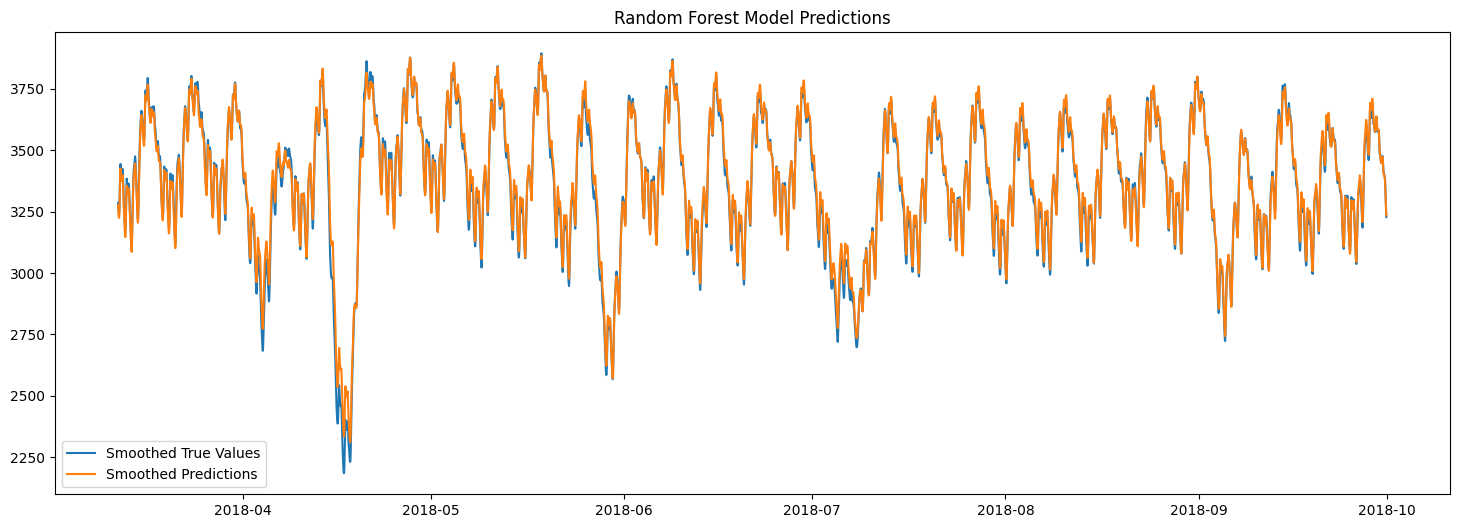

In [34]:
random_forest_params = {'n_estimators': 76, 'max_depth': 31, 'min_samples_split': 3, 'min_samples_leaf': 4}
rf_model = RandomForestRegressor(**random_forest_params, random_state=42, n_jobs=-1)

rf_y_test_pred, rf_y_train_pred , _, _, _ = expanding_window_evaluation(rf_model, X_train, y_train, X_test, y_test)

y_test_smooth = y_test.rolling(window=100).mean()
rf_y_test_pred_smooth = pd.Series(rf_y_test_pred).rolling(window=100).mean()
plt.figure(figsize=(18, 6))
plt.plot(y_test.index, y_test_smooth, label='Smoothed True Values')
plt.plot(y_test.index, rf_y_test_pred_smooth, label='Smoothed Predictions')
plt.legend()
plt.title('Random Forest Model Predictions')
plt.show()

- **Mean MAE** : 186.9194
- **Mean RMSE** : 286.3531
- **Mean R²** : 0.9779

Ces valeurs moyennes confirment que le modèle a une très bonne précision globale.

- **Bonne adéquation globale** : Les prédictions (courbe orange) suivent de près les valeurs réelles (courbe bleue), ce qui indique que le modèle capture bien la tendance et la saisonnalité des données.
- **Écarts aux extrêmes** : On observe quelques divergences sur les pics et les creux, ce qui est courant pour les modèles basés sur les arbres, qui peuvent avoir du mal à généraliser sur des valeurs extrêmes.
- **Prédictions stables** : Le modèle ne montre pas de fluctuations excessives, suggérant une bonne robustesse dans les prévisions.

Le **Random Forest** donne des résultats prometteurs en capturant efficacement la structure des données. Toutefois, une comparaison avec d'autres modèles et un affinement des paramètres pourraient encore améliorer les performances.


#### **Modèle 2: LightGBM**

Train Size: 3317, Validation MAE: 228.0867, RMSE: 337.4503, R²: 0.9696
Train Size: 6630, Validation MAE: 204.0559, RMSE: 295.4462, R²: 0.9748
Train Size: 9943, Validation MAE: 169.7122, RMSE: 265.9497, R²: 0.9824
Train Size: 13256, Validation MAE: 164.7417, RMSE: 245.4005, R²: 0.9846
Train Size: 16569, Validation MAE: 165.9079, RMSE: 258.2433, R²: 0.9824

Aggregated Validation Metrics:
Mean MAE: 186.5009, Mean RMSE: 280.4980, Mean R²: 0.9788

Final Test Metrics:
Test MAE: 141.7614, Test RMSE: 215.4981, Test R²: 0.9882


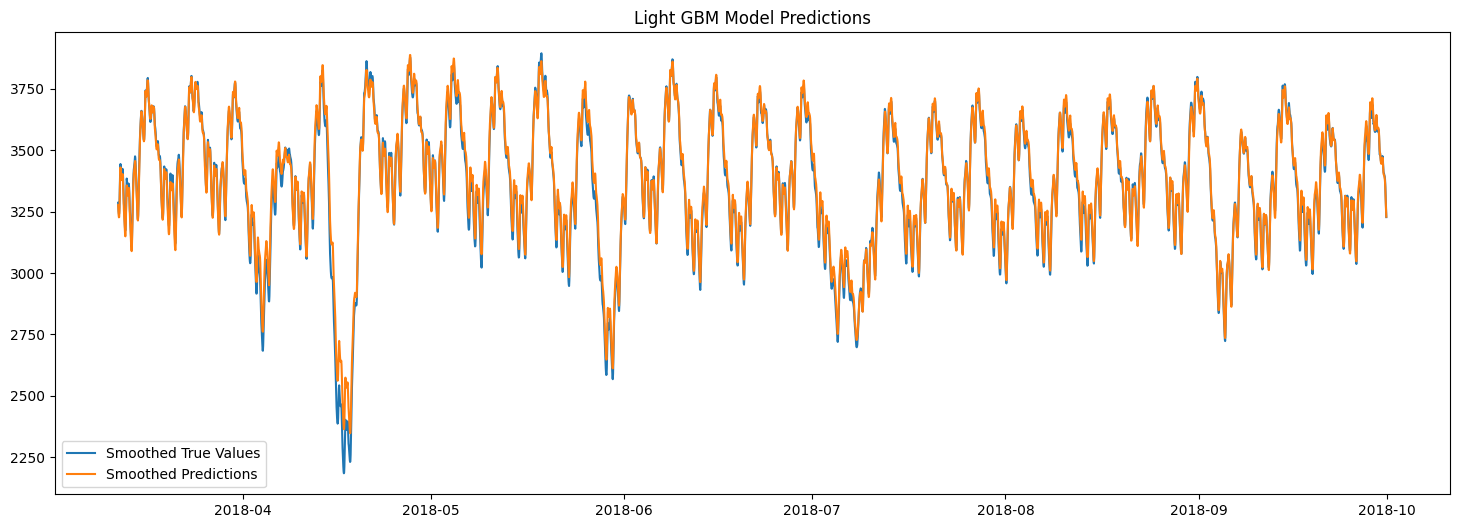

In [35]:
lgbm_params = {'num_leaves': 86, 'learning_rate': 0.1328649875508889, 'n_estimators': 53, 'reg_alpha': 0.008353026155638616, 'reg_lambda': 0.0006578888189568428}
lgbm_model = LGBMRegressor(**lgbm_params, random_state=42, verbose=0)
lgbm_y_test_pred, lgbm_y_train_pred , _, _, _  = expanding_window_evaluation(lgbm_model, X_train, y_train, X_test, y_test)

lgbm_y_test_pred_smooth = pd.Series(lgbm_y_test_pred).rolling(window=100).mean()
plt.figure(figsize=(18, 6))
plt.plot(y_test.index, y_test_smooth, label='Smoothed True Values')
plt.plot(y_test.index, lgbm_y_test_pred_smooth, label='Smoothed Predictions')
plt.legend()
plt.title('Light GBM Model Predictions')
plt.show()

**Amélioration progressive** : On observe une diminution du **MAE** et du **RMSE** au fur et à mesure que la taille d'entraînement augmente.
- **R² élevé et stable** : Le **coefficient de détermination (R²)** est très élevé, atteignant **0.98**, ce qui montre que le modèle LightGBM explique bien la variance des données.
- **Meilleure généralisation que Random Forest** : Comparé à Random Forest, LightGBM affiche un **MAE plus faible** en validation et un **meilleur RMSE global**, suggérant qu’il pourrait être plus performant.

- **LightGBM** a une **meilleure capacité de généralisation** que **Random Forest**, avec un **MAE et un RMSE légèrement inférieurs**.
- **Meilleur équilibre entre biais et variance**, grâce à la régularisation et à la structure en histogramme du boosting.
- **Temps d'entraînement réduit** par rapport à Random Forest, un avantage pour des mises à jour fréquentes.


**Importance des variables explicatives**

In [36]:
rf_importances = rf_model.feature_importances_
lgbm_importances = lgbm_model.feature_importances_

feature_names = X_train.columns  

df_feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Random Forest": rf_importances,
    "LightGBM": lgbm_importances
})

df_feature_importance = df_feature_importance.sort_values(by="Random Forest", ascending=False)

df_long = df_feature_importance.melt(id_vars=["Feature"], var_name="Modèle", value_name="Importance")

fig = px.bar(df_long, 
             x="Feature", 
             y="Importance", 
             color="Modèle", 
             barmode="group",
             title="Comparaison de l'Importance des Features (Random Forest vs LightGBM)",
             labels={"Importance": "Importance", "Feature": "Feature"},
             height=600)

fig.update_layout(xaxis=dict(tickangle=-45), showlegend=True)
fig.show()

- **Les deux modèles utilisent les mêmes variables, mais leur importance varie.**
- **LightGBM** (graphique du haut, en rouge) répartit l'importance de manière plus équilibrée sur plusieurs variables.
- **Random Forest** (graphique du bas, en bleu) donne une importance écrasante à une seule feature (`lag_1`), ce qui pourrait indiquer une forte dépendance.

 **LightGBM (graphique rouge)**
- **`lag_1`** est la variable la plus influente, mais d’autres variables comme **`lag_24`, `lag_23`, `Hour_cos`, `Hour_sin` et `Day_sin`** contribuent significativement.
- Une meilleure répartition de l'importance sur plusieurs features peut rendre LightGBM plus robuste aux variations des données.
- La prise en compte des **statistiques glissantes (rolling mean, rolling std)** et des caractéristiques temporelles (sinus et cosinus des heures/jours) montre que LightGBM capte mieux les tendances complexes.

 **Random Forest (graphique bleu)**
- **Une très forte dépendance à `lag_1`**, qui représente la valeur précédente immédiate. Cela signifie que le modèle prédit principalement en fonction de la dernière valeur connue.
- Les autres features ont une importance négligeable, ce qui peut indiquer un **sur-ajustement** ou une **faible capacité de généralisation**.
- Moins de prise en compte des tendances à long terme, ce qui peut rendre Random Forest moins performant sur des séries temporelles avec des cycles complexes.

- **LightGBM semble mieux équilibré** : il répartit l’importance sur plusieurs variables pertinentes, ce qui améliore sa capacité à capturer les tendances sous-jacentes.
- **Random Forest est plus myope** : il s'appuie principalement sur `lag_1`, ce qui peut fonctionner à court terme mais être moins efficace pour les prévisions à plus long terme.


#### **Prédire à des horizons plus éloignés**

Pour effectuer des prévisions multi-horizons, nous avons utilisé une **approche récursive**. Cette méthode consiste à **prédire une valeur future à partir des données actuelles**, puis à **réinjecter cette prédiction** dans le modèle comme une nouvelle entrée pour prédire l’horizon suivant.

 **Étapes de la prévision récursive**
1. **Prédiction initiale** : Le modèle génère une première estimation à partir des features disponibles.
2. **Mise à jour des entrées** : Les colonnes de décalage (`lag features`) sont ajustées pour intégrer la nouvelle prédiction.
3. **Boucle sur l’horizon de prévision** : Ce processus est répété pour générer les prévisions successives (ex: prédiction à 1h, 2h, … jusqu’à `horizon=5`).


In [37]:
def recursive_forecast(model, X_test, horizon=5):
    X_test_copy = X_test.copy()
    predictions = np.zeros((len(X_test), horizon))
    lag_columns = [col for col in X_test.columns if 'lag' in col]
 
    for h in range(horizon):
        X_test_copy = X_test_copy.astype(float)
        y_pred = model.predict(X_test_copy)
        predictions[:, h] = y_pred
        X_test_copy[lag_columns] = X_test_copy[lag_columns].shift(-1, axis=1)
        X_test_copy.loc[:, 'lag_1'] = y_pred
    return predictions

predictions_rf = recursive_forecast(rf_model, X_test, horizon=5)
predictions_lgbm = recursive_forecast(lgbm_model, X_test, horizon=5)

# evaluation
for h in range(5):
    mae_rf, rmse_rf, r2_rf = evaluate_predictions(y_test, predictions_rf[:, h])
    mae_lgbm, rmse_lgbm, r2_lgbm = evaluate_predictions(y_test, predictions_lgbm[:, h])
    print(f"Horizon {h+1} - Random Forest: MAE={mae_rf:.2f}, RMSE={rmse_rf:.2f}, R2={r2_rf:.2f}")
    print(f"Horizon {h+1} - Light GBM: MAE={mae_lgbm:.2f}, RMSE={rmse_lgbm:.2f}, R2={r2_lgbm:.2f}")
    print()

Horizon 1 - Random Forest: MAE=140.36, RMSE=219.18, R2=0.99
Horizon 1 - Light GBM: MAE=141.76, RMSE=215.50, R2=0.99

Horizon 2 - Random Forest: MAE=320.27, RMSE=432.85, R2=0.95
Horizon 2 - Light GBM: MAE=358.07, RMSE=484.57, R2=0.94

Horizon 3 - Random Forest: MAE=498.72, RMSE=646.37, R2=0.89
Horizon 3 - Light GBM: MAE=580.20, RMSE=757.22, R2=0.85

Horizon 4 - Random Forest: MAE=573.59, RMSE=764.25, R2=0.85
Horizon 4 - Light GBM: MAE=579.96, RMSE=744.76, R2=0.86

Horizon 5 - Random Forest: MAE=614.28, RMSE=819.81, R2=0.83
Horizon 5 - Light GBM: MAE=794.71, RMSE=1052.54, R2=0.72



In [38]:
time_index = y_test.index[-500:]  

def plot_interactive_predictions(predictions_to_show):
    plt.figure(figsize=(12, 6))
    plt.plot(time_index, y_test[-500:], label="Vraies valeurs", linestyle="dashed", color="black")
    
    color_map = {
        "t+1": "blue",
        "t+2": "green",
        "t+3": "red",
        "t+4": "purple",
        "t+5": "orange"
    }
    
    for pred in predictions_to_show:
        t = int(pred[-1]) - 1
        plt.plot(time_index, predictions_rf[-500:, t], label=f"RF {pred}", color=color_map[pred])
        plt.plot(time_index, predictions_lgbm[-500:, t], label=f"LGBM {pred}", linestyle="dotted", color=color_map[pred])
    
    plt.legend()
    plt.title("Prédictions Récursives t+1 → t+5 (RF & LGBM)")
    plt.xlabel("Heure")
    plt.ylabel("Valeur prédite")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

predictions_dropdown = widgets.SelectMultiple(
    options=["t+1", "t+2", "t+3", "t+4", "t+5"],
    value=["t+1"],
    description='Prédictions:',
    layout=widgets.Layout(width='200px')
)

widgets.interactive(plot_interactive_predictions, predictions_to_show=predictions_dropdown)


interactive(children=(SelectMultiple(description='Prédictions:', index=(0,), layout=Layout(width='200px'), opt…

Il est évident que les erreurs se propagent progressivement à mesure que l'horizon de prévision s'allonge. Il serait donc intéressant d'explorer d'autres approches, telles que la méthode directe ou DirREC.

## **4.1. Modèle de deep learning**

Nous allons tester plusieurs architectures de réseaux neuronaux récurrents et convolutifs afin d'évaluer leurs performances sur la prédiction de la série. Pour cette première phase, nous allons nous concentrer sur des modèles de type :

- Long Short-Term Memory (LSTM) : Un réseau neuronal récurrent (RNN) adapté aux données séquentielles, particulièrement efficace pour capturer les dépendances à long terme.
- Convolutional Neural Networks (CNN) : Une approche généralement utilisée pour le traitement d'images, mais qui a montré son efficacité dans l'apprentissage des motifs temporels.
- TCNN:...

Pour cette première série d'expérimentations, nous allons utiliser la série temporelle brute avec une approche strictement séquentielle :

- Utilisation des lags : Nous structurerons nos données en créant des fenêtres glissantes pour capturer la dépendance temporelle.
- Suppression des variables contextuelles : À cette étape, nous nous focaliserons uniquement sur la série temporelle elle-même, sans inclure d'autres variables exogènes.

Cette approche permettra d'évaluer la capacité intrinsèque de ces modèles à apprendre les dynamiques temporelles directement à partir des données historiques, avant d'éventuellement enrichir notre analyse avec des variables additionnelles.

#### **Modèle 1: LSTM**

Nous allons implémenter un réseau de neurones récurrent basé sur des neurones **LSTM (Long Short-Term Memory)**, conçu pour la prédiction de séries temporelles.
- Une couche d'entrée prenant en charge des séquences de longueur `time_steps`.
  - Deux couches **LSTM** avec 64 unités chacune :
    - La première retourne toute la séquence (`return_sequences=True`).
    - La seconde ne retourne que la dernière sortie (`return_sequences=False`).
  - Deux couches de **Dropout** (0.1) pour réduire le sur-apprentissage.
  - Une couche **Dense** avec 32 neurones et activation **ReLU**.
  - Une couche de sortie **Dense** avec `prediction_horizon` unités (prédictions).

- La fonction de perte utilisée est la **RMSE (Root Mean Square Error)**.

In [39]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

time_steps = 24  
prediction_horizon = 5

def create_sequences(X, y, time_steps, horizon):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - horizon + 1):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps:i + time_steps + horizon])
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = create_sequences(y_train_scaled, y_train_scaled, time_steps, prediction_horizon)
X_test_lstm, y_test_lstm = create_sequences(y_test_scaled, y_test_scaled, time_steps, prediction_horizon)

# Vérification des dimensions
print(f"X_train shape: {X_train_lstm.shape}")
print(f"y_train shape: {y_train_lstm.shape}")

X_train shape: (19854, 24, 1)
y_train shape: (19854, 5, 1)


In [40]:
tf.random.set_seed(1)

def rmse_loss(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_true - y_pred)))

model_lstm = Sequential([
    tf.keras.layers.Input(shape=(time_steps, 1)),
    LSTM(units=64, return_sequences=True),
    Dropout(0.1),
    LSTM(units=64, return_sequences=False),
    Dropout(0.1),
    Dense(units=32, activation='relu'),
    Dense(units=prediction_horizon)  
])


model_lstm.compile(optimizer='adam', loss=rmse_loss)
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=0)

y_pred_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [41]:
for t in range(prediction_horizon):
    mae, rmse, r2 = evaluate_predictions(y_test[time_steps:time_steps + len(y_pred_lstm[:, t])], y_pred_lstm[:, t])
    print(f"Time Step {t+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")

Time Step 1: MAE=247.07, RMSE=312.79, R2=0.98
Time Step 2: MAE=544.47, RMSE=744.98, R2=0.86
Time Step 3: MAE=1003.40, RMSE=1342.34, R2=0.54
Time Step 4: MAE=1453.81, RMSE=1835.64, R2=0.15
Time Step 5: MAE=1773.46, RMSE=2186.88, R2=-0.21


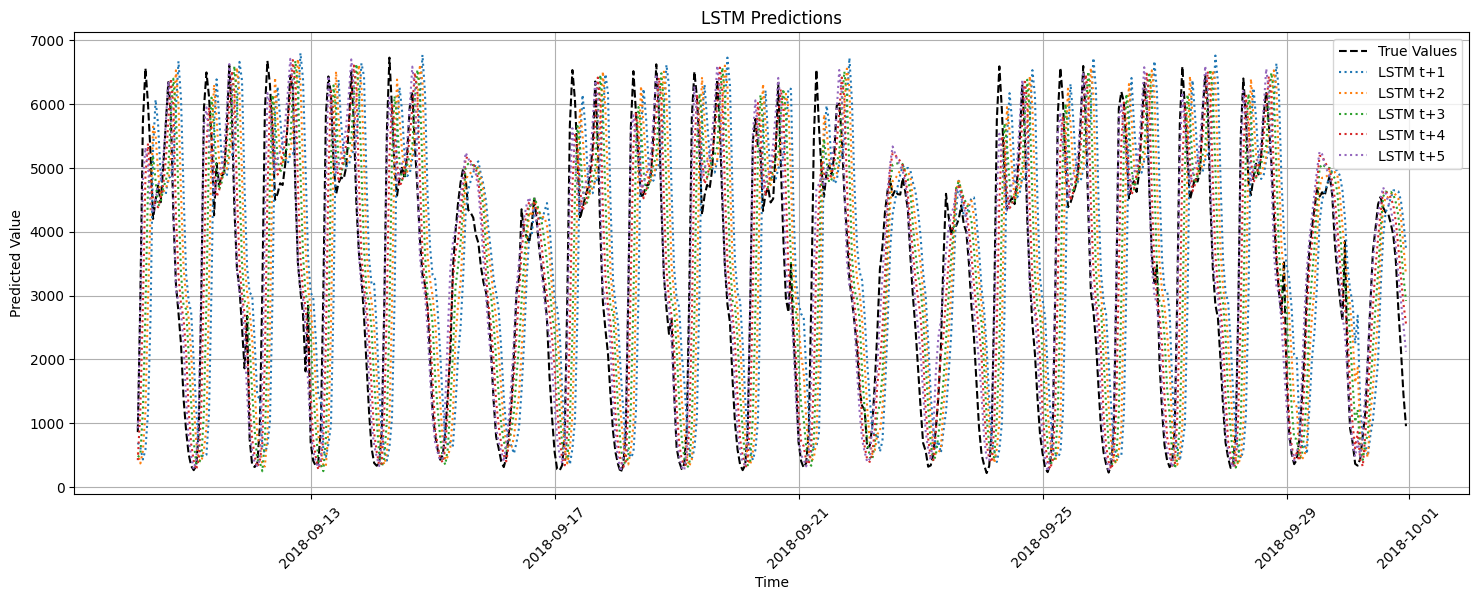

In [42]:
# plot predictions
time_index = y_test.index[-500:]

plt.figure(figsize=(18, 6))
plt.plot(time_index, y_test[-500:], label="True Values", linestyle="dashed", color="black")
for t in range(prediction_horizon):
    plt.plot(time_index, y_pred_lstm[-500:, t], label=f"LSTM t+{t+1}", linestyle="dotted")
plt.legend()
plt.title("LSTM Predictions")
plt.xlabel("Time")
plt.ylabel("Predicted Value")
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

#### **Modèle 2: CNN**

In [43]:
X_train_cnn, y_train_cnn = create_sequences(y_train_scaled, y_train_scaled, time_steps, prediction_horizon)
X_test_cnn, y_test_cnn = create_sequences(y_test_scaled, y_test_scaled, time_steps, prediction_horizon)

model_cnn = Sequential([
    tf.keras.layers.Input(shape=(time_steps, 1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=prediction_horizon)
])

model_cnn.compile(optimizer='adam', loss='mse')

model_cnn.fit(X_train_cnn, y_train_cnn, epochs=20, batch_size=64, validation_data=(X_test_cnn, y_test_cnn), verbose=0)

y_pred_cnn = model_cnn.predict(X_test_cnn)
y_pred_cnn = scaler_y.inverse_transform(y_pred_cnn)

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [44]:
for t in range(prediction_horizon):
    mae, rmse, r2 = evaluate_predictions(y_test[time_steps:time_steps + len(y_pred_cnn[:, t])], y_pred_cnn[:, t])
    print(f"Time Step {t+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")

Time Step 1: MAE=283.54, RMSE=360.11, R2=0.97
Time Step 2: MAE=554.52, RMSE=748.60, R2=0.86
Time Step 3: MAE=997.14, RMSE=1311.07, R2=0.56
Time Step 4: MAE=1429.59, RMSE=1786.21, R2=0.19
Time Step 5: MAE=1755.72, RMSE=2160.31, R2=-0.18


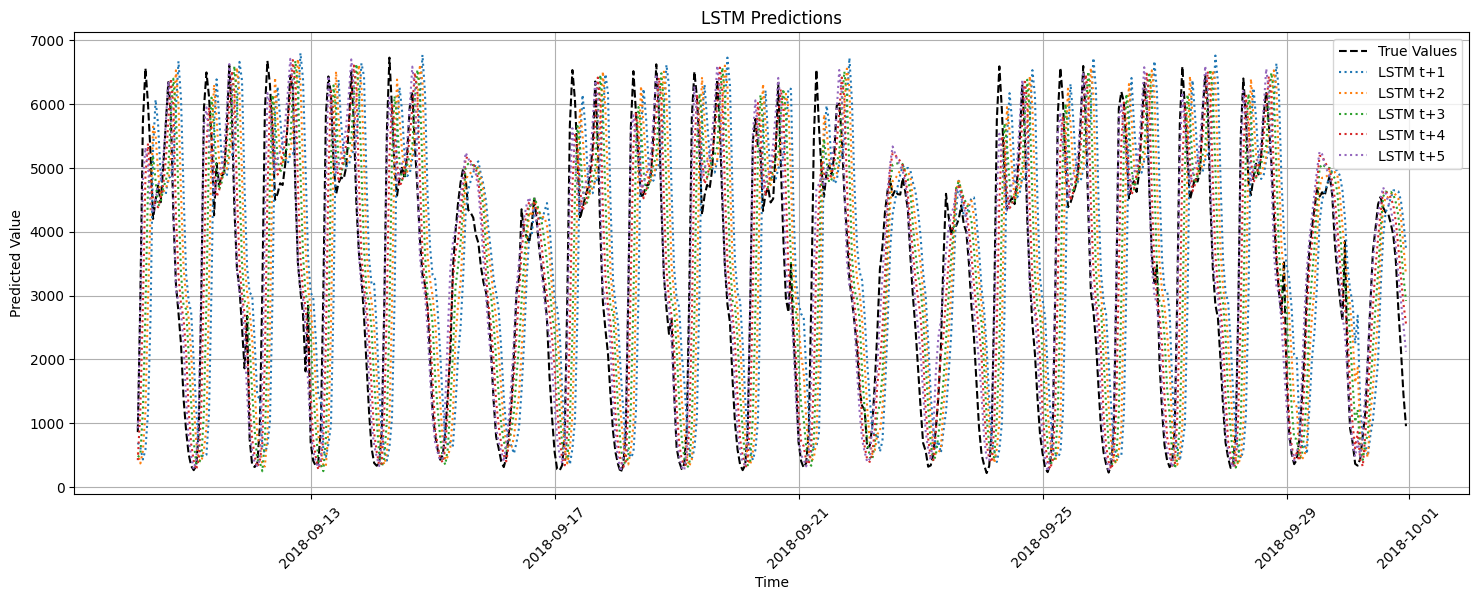

In [45]:
# plot predictions
time_index = y_test.index[-500:]  # Define time_index

plt.figure(figsize=(18, 6))
plt.plot(time_index, y_test[-500:], label="True Values", linestyle="dashed", color="black")
for t in range(prediction_horizon):
    plt.plot(time_index, y_pred_lstm[-500:, t], label=f"LSTM t+{t+1}", linestyle="dotted")
plt.legend()
plt.title("LSTM Predictions")
plt.xlabel("Time")
plt.ylabel("Predicted Value")
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

#### **Modèle 3: TCN**

In [46]:
# X_train_tcn, y_train_tcn = create_sequences(y_train_scaled, y_train_scaled, time_steps, prediction_horizon)
# X_test_tcn, y_test_tcn = create_sequences(y_test_scaled, y_test_scaled, time_steps, prediction_horizon)

# model_tcn = Sequential([
#     tf.keras.layers.Input(shape=(time_steps,1 )),
#     TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4], return_sequences=False),
#     Dense(units=32, activation='relu'),
#     Dense(units=prediction_horizon)
# ])

# model_tcn = Sequential([
#     tf.keras.layers.Input(shape=(time_steps,1 )),
#     tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=prediction_horizon)
# ])

In [47]:
# for t in range(prediction_horizon):
#     mae, rmse, r2 = evaluate_predictions(y_test[time_steps:time_steps + len(y_pred_tcn[:, t])], y_pred_tcn[:, t])
#     print(f"Time Step {t+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")

In [48]:
# # plot predictions
# time_index = y_test.index[-500:]  # Define time_index

# plt.figure(figsize=(18, 6))
# plt.plot(time_index, y_test[-500:], label="True Values", linestyle="dashed", color="black")
# for t in range(prediction_horizon):
#     plt.plot(time_index, y_pred_tcn[-500:, t], label=f"tcn t+{t+1}", linestyle="dotted")
# plt.legend()
# plt.title("LSTM Predictions")
# plt.xlabel("Time")
# plt.ylabel("Predicted Value")
# plt.xticks(rotation=45)

# plt.grid(True)
# plt.show()

### **Comment inclure les variables contextuelles dans un RNN?**

Nous voyons que les performances sont moindre avec des réseaux de neurones récurrents qu'avec des réseaux....

In [50]:
categorical_features = ["weather_main", 'Weekend', 'Hour_sin', 'Hour_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos']

time_series_features = ['rolling_mean_daily', 'rolling_mean_weekly', 'rolling_mean_monthly',
       'rolling_median_daily', 'rolling_median_weekly',
       'rolling_median_monthly', 'rolling_std_daily', 'rolling_std_weekly',
       'rolling_std_monthly']

def create_sequences(X, y, time_steps, horizon):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - horizon + 1):
        Xs.append(X.iloc[i:i + time_steps].values)  # Séquence des time series
        ys.append(y.iloc[i + time_steps:i + time_steps + horizon].values.flatten())  # Cible
    return np.array(Xs), np.array(ys)

X_time_series_train = pd.concat([X_train[time_series_features], y_train], axis=1)
X_time_series_test = pd.concat([X_test[time_series_features], y_test], axis=1)

X_time_series_train, y_time_series_train = create_sequences(X_time_series_train, y_train, time_steps, prediction_horizon)
X_time_series_test, y_time_series_test = create_sequences(X_time_series_test, y_test, time_steps, prediction_horizon)

print(f"Time Series Train Shape: {X_time_series_train.shape}, {y_time_series_train.shape}")
print(f"Time Series Test Shape: {X_time_series_test.shape}, {y_time_series_test.shape}")

categorical_train = X_train[categorical_features]
categorical_train = categorical_train[:len(X_time_series_train)]
categorical_test = X_test[categorical_features]
categorical_test = categorical_test[:len(X_time_series_test)]


print("Categorical Train Shape:", categorical_train.shape)
print("Categorical Test Shape:", categorical_test.shape)


Time Series Train Shape: (19854, 24, 10), (19854, 5)
Time Series Test Shape: (4943, 24, 10), (4943, 5)
Categorical Train Shape: (19854, 8)
Categorical Test Shape: (4943, 8)


In [51]:
input_seq = Input(shape=(time_steps, X_time_series_train.shape[-1]), name="input_sequence")

input_context = Input(shape=(categorical_train.shape[-1],), name="input_context")
x = LSTM(units=64, return_sequences=True)(input_seq)
x = LSTM(units=64, return_sequences=False)(x)
merged = Concatenate()([x, input_context])

dense1 = Dense(units=32, activation='relu')(merged)
output = Dense(units=prediction_horizon, activation='linear')(dense1)

model_lstm = Model(inputs=[input_seq, input_context], outputs=output)

model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_lstm.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 24, 64)    │     19,200 │ input_sequence[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     33,024 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_context       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 72)        │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ input_context[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,336 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5)         │        165 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 54,725 (213.77 KB)

 Trainable params: 54,725 (213.77 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history = model_lstm.fit(
    [X_time_series_train, categorical_train], y_time_series_train,
    validation_data=([X_time_series_test, categorical_test], y_time_series_test),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 7641992.0000 - mae: 2281.1406 - val_loss: 3908628.5000 - val_mae: 1724.5540
Epoch 2/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 3790156.7500 - mae: 1699.1316 - val_loss: 3893139.7500 - val_mae: 1720.6603
Epoch 3/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 3701236.2500 - mae: 1676.3625 - val_loss: 3592162.5000 - val_mae: 1642.3680
Epoch 4/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 3409564.7500 - mae: 1599.3689 - val_loss: 3246682.5000 - val_mae: 1555.5475
Epoch 5/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 2979823.0000 - mae: 1481.1456 - val_loss: 2590110.2500 - val_mae: 1371.1318
Epoch 6/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 2367507.5000 - mae: 1298.8116 - val_loss: 2062091.7500 - val_mae: 1185.3926
Epoch 7/20
621/621 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 1869042.6250 - mae: 1124.9655 - val_loss: 1683170.2500 - val_mae: 1031.4324
Epoch 8/20
621/621 ━━━━━━━━━━━━━━━

In [53]:
y_test_pred_lstm = model_lstm.predict([X_time_series_test, categorical_test])

for t in range(prediction_horizon):
    mae, rmse, r2 = evaluate_predictions(y_test[time_steps:time_steps + len(y_pred_lstm[:, t])], y_pred_lstm[:, t])
    print(f"Time Step {t+1}: MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Time Step 1: MAE=247.07, RMSE=312.79, R2=0.98
Time Step 2: MAE=544.47, RMSE=744.98, R2=0.86
Time Step 3: MAE=1003.40, RMSE=1342.34, R2=0.54
Time Step 4: MAE=1453.81, RMSE=1835.64, R2=0.15
Time Step 5: MAE=1773.46, RMSE=2186.88, R2=-0.21


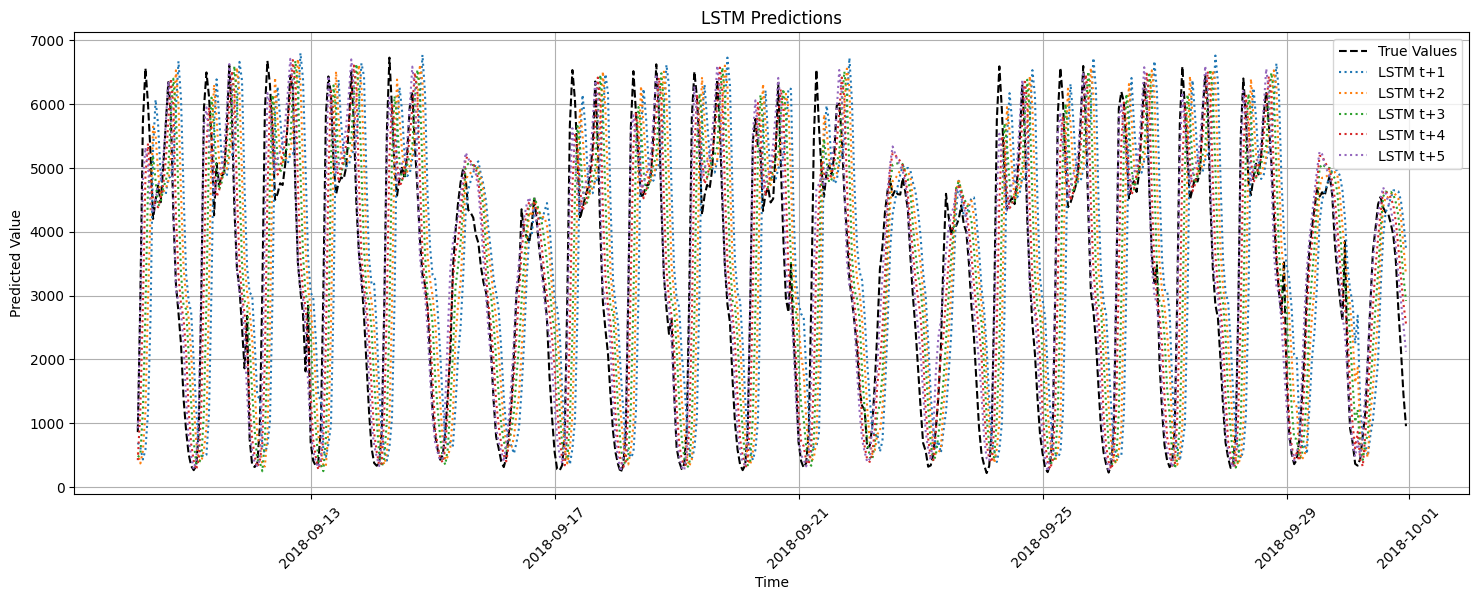

In [54]:
# plot predictions
time_index = y_test.index[-500:]  # Define time_index

plt.figure(figsize=(18, 6))
plt.plot(time_index, y_test[-500:], label="True Values", linestyle="dashed", color="black")
for t in range(prediction_horizon):
    plt.plot(time_index, y_pred_lstm[-500:, t], label=f"LSTM t+{t+1}", linestyle="dotted")
plt.legend()
plt.title("LSTM Predictions")
plt.xlabel("Time")
plt.ylabel("Predicted Value")
plt.xticks(rotation=45)

plt.grid(True)
plt.show()

# Conclusion